In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# For spliting dataset
from sklearn.model_selection import train_test_split

# For preprocessing data
import re
import nltk
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For building the model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Embedding, Dropout,
    GlobalAveragePooling1D, Input
)
from tensorflow.keras.models import Model

In [2]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
data_path = "/kaggle/input/sms-spam-collection-dataset/spam.csv"


In [6]:
df = pd.read_csv('/content/drive/MyDrive/archive (2).zip',encoding='ISO-8859-1')
df = df[['v1', 'v2']]
df.columns = ['Category', 'Content']
df.head()

,Category,Content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

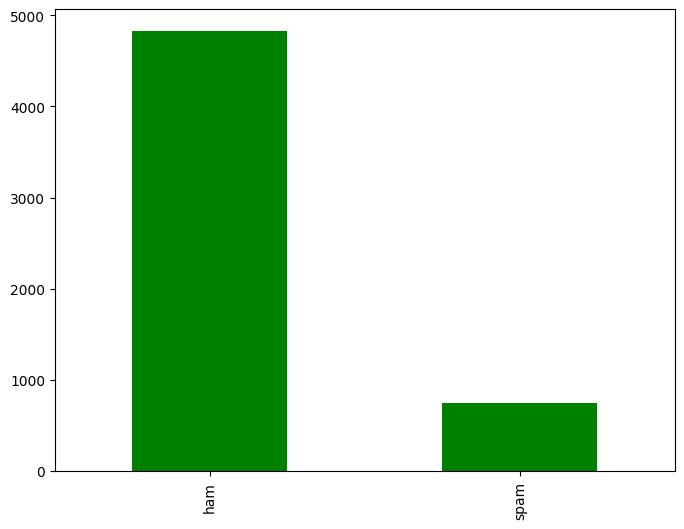

In [7]:
plt.figure(figsize=(8, 6))
df.Category.value_counts().plot(kind='bar', color='green')

In [9]:
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [11]:
def clean_text(text):
    # Remove punctuation from text
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    # Get Origin of words (books -> book)
    text = " ".join([ps.stem(word) for word in tokens if word not in stopwords])
    return text

In [12]:
df['Clean_text'] = df['Content'].apply(lambda x: clean_text(x))
df.head()

,Category,Content,Clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [13]:
# {ham:0, spam:1}
df['label'] = df['Category'].astype('category').cat.codes
df.head()

,Category,Content,Clean_text,label
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...,1
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though,0


In [14]:
X_train,X_test,y_train,y_test=train_test_split(df['Clean_text'],df['label'],test_size=0.25,random_state=SEED)

In [15]:
max_len=50 # max words in every input string
trunc_type='post' # if number of words are more than max_len then trunct from the last of the string
padding_type='post' # if number of words are less than max_len then add
oov_token_1='<OOV>'# out of vocabulary token
vocab_size=500

In [16]:
tokenizer=Tokenizer(num_words=vocab_size,char_level=False,oov_token=oov_token_1)
tokenizer.fit_on_texts(X_train)

In [17]:
print(f"Total token : {len(tokenizer.word_index)}")
for token_word in tokenizer.word_index:
    print(f"{token_word}: {tokenizer.word_index[token_word]}")
    if tokenizer.word_index[token_word] >10:
        break

Total token : 6851
<OOV>: 1
u: 2
call: 3
2: 4
im: 5
go: 6
get: 7
ur: 8
å: 9
come: 10
4: 11


In [18]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen=max_len,padding=padding_type,truncating=trunc_type)

In [19]:
X_test=tokenizer.texts_to_sequences(X_test)
X_test=pad_sequences(X_test,maxlen=max_len,padding=padding_type,truncating=trunc_type)

In [20]:
X_train.shape, X_test.shape

((4179, 50), (1393, 50))

In [21]:
input_shape = X_train.shape[1:]
input_shape

(50,)

In [22]:
input = Input(shape=input_shape)
x = Embedding(input_dim=vocab_size, output_dim=12)(input)
x = GlobalAveragePooling1D()(x)
x = Dense(24, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input, outputs=output)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 12)            6000      
                                                                 
 global_average_pooling1d (G  (None, 12)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                312       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                             

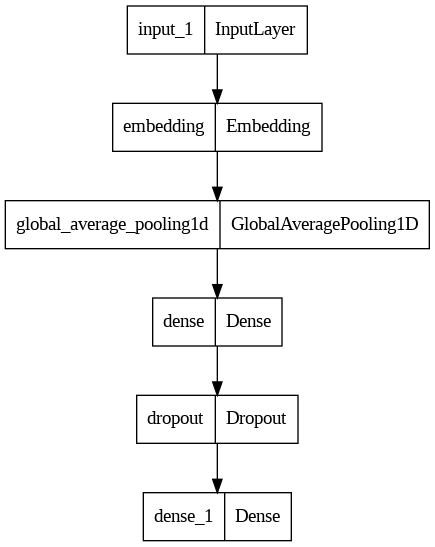

In [24]:
tf.keras.utils.plot_model(model)

In [25]:
num_epochs=5
# If val_loss increases five times it will stop model fitting
early_stop=EarlyStopping(monitor='val_loss',patience=5)
history=model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    validation_data=(X_test,y_test),
    callbacks=[early_stop]
)

Epoch 1/5
131/131 [==============================] - 2s 9ms/step - loss: 0.5195 - accuracy: 0.8665 - val_loss: 0.3688 - val_accuracy: 0.8629
Epoch 2/5
131/131 [==============================] - 1s 5ms/step - loss: 0.3353 - accuracy: 0.8670 - val_loss: 0.3125 - val_accuracy: 0.8629
Epoch 3/5
131/131 [==============================] - 1s 5ms/step - loss: 0.2825 - accuracy: 0.8670 - val_loss: 0.2538 - val_accuracy: 0.8629
Epoch 4/5
131/131 [==============================] - 1s 5ms/step - loss: 0.2215 - accuracy: 0.8942 - val_loss: 0.1972 - val_accuracy: 0.9275
Epoch 5/5
131/131 [==============================] - 1s 6ms/step - loss: 0.1651 - accuracy: 0.9442 - val_loss: 0.1540 - val_accuracy: 0.9483


In [26]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 2ms/step - loss: 0.1540 - accuracy: 0.9483


[0.153997540473938, 0.9483129978179932]

In [27]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

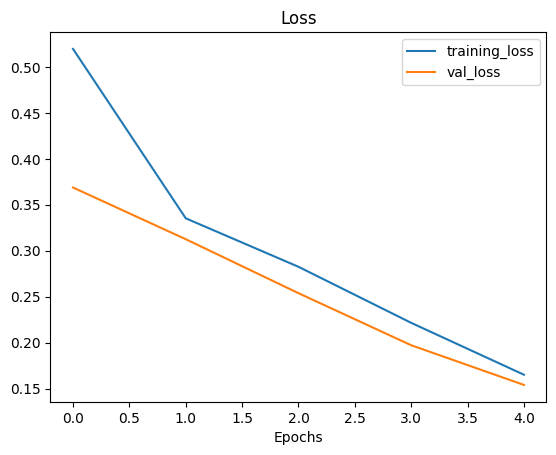

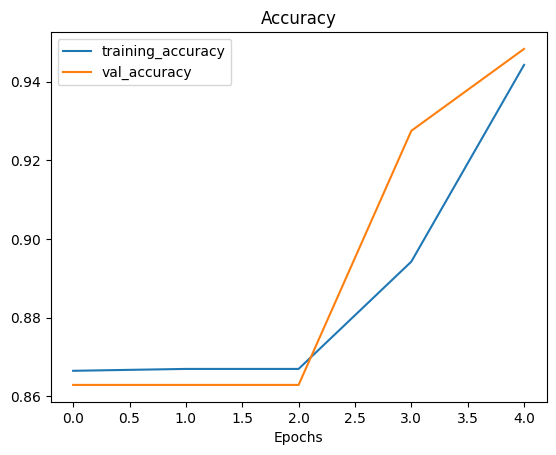

In [28]:
plot_loss_curves(history)

In [29]:
import joblib
joblib.dump(history,'spam')

['spam']